#Generative Differential Expression Analysis

In this notebook, I perform generative differential expression (DE) analysis using a probabilistic deep learning model trained on the processed bulk RNA-seq data prepared in the previous notebook. Rather than testing genes independently for association with predefined conditions, the objective here is to learn a low-dimensional latent representation of biological state and model gene expression as a smooth, uncertainty-aware function of this latent space.

Specifically, I implement a **Negative Binomial Variational Autoencoder** (NB-VAE) to capture shared structure across genes while explicitly modeling RNA-seq count noise and sample-specific sequencing depth. After training the model, I derive **generative log fold-change estimates** by comparing expected gene expression under latent representations corresponding to lactation and virgin samples.

Finally, all generative DE results and enrichment outputs are saved for downstream interpretation and comparison with the classical DESeq2 results.

#NOTE:
This notebook is intended to be run after completing Notebook 1 and executing the DESeq2 analysis in R, as it relies on the processed count matrix, metadata, and DESeq2 results generated in those steps.

Importing necessary libraries...

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

PyTorch is used to define and train the neural network components of the generative model, including the encoder, decoder, and optimization routines.

In [ ]:
from torch.distributions import NegativeBinomial

The Negative Binomial distribution is imported to explicitly model RNA-seq count data and account for overdispersion in gene expression.

In [ ]:
import random

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

Random seeds are fixed to ensure reproducibility of model initialization, sampling, and training behavior across runs.

Reading all the data...

In [ ]:
counts = pd.read_csv("counts_matrix.tsv", sep="\t", index_col=0)
metadata = pd.read_csv("metadata.tsv", sep="\t", index_col=0)
deseq2 = pd.read_csv("deseq2_results.csv", index_col=0)
counts_filtered = counts.loc[deseq2.index]

The counts_filtered matrix is subset to genes present in the DESeq2 results to ensure a consistent gene universe across classical and generative analyses. DESeq2 internally filters out low-count genes that do not meet minimum expression thresholds (counts less than 10 in all samples), resulting in a reduced set of 18,418 genes compared to the original 27,129 genes in the raw count matrix. Restricting the analysis to this filtered gene set ensures alignment between model inputs and downstream comparisons.

In [ ]:
print(counts.shape)
print(metadata["condition"].value_counts())
print(deseq2.shape)
print(counts_filtered.shape)

(27179, 12)
condition
virgin       6
lactation    6
Name: count, dtype: int64
(18418, 6)
(18418, 12)


Size factors estimated by DESeq2 are used directly rather than being learned within the generative model. DESeq2’s size factor estimation is a well-established and robust procedure for normalizing sequencing depth in bulk RNA-seq data. Fixing these normalization offsets allows the generative model to focus on learning biologically meaningful variation in gene expression, rather than confounding biological signal with technical differences in library size.

In [ ]:
size_factors = pd.read_csv("size_factors.tsv", sep="\t")
size_factors

,sample,size_factor
0,MCL1-DG_BC2CTUACXX_ACTTGA_L002_R1,1.293490
1,MCL1-DH_BC2CTUACXX_CAGATC_L002_R1,1.193371
2,MCL1-DI_BC2CTUACXX_ACAGTG_L002_R1,1.211314
3,MCL1-DJ_BC2CTUACXX_CGATGT_L002_R1,1.076862
4,MCL1-DK_BC2CTUACXX_TTAGGC_L002_R1,0.985908
5,MCL1-DL_BC2CTUACXX_ATCACG_L002_R1,0.972989
6,MCL1-LA_BC2CTUACXX_GATCAG_L001_R1,1.282215
7,MCL1-LB_BC2CTUACXX_TGACCA_L001_R1,1.361540
8,MCL1-LC_BC2CTUACXX_GCCAAT_L001_R1,1.031562
9,MCL1-LD_BC2CTUACXX_GGCTAC_L001_R1,0.919018


Size factors are reordered to match the column order of the count matrix and transformed to the log scale for use as additive offsets in the decoder. This ensures correct sample-to-sample alignment and numerically stable integration of sequencing depth normalization within the generative model.

In [ ]:
size_factors = (
    size_factors
    .set_index("sample")
    .loc[counts.columns]
)

log_size_factors = torch.log(
    torch.tensor(size_factors["size_factor"].values, dtype=torch.float32)
)

In [ ]:
print(log_size_factors.shape)

torch.Size([12])


In [ ]:
X = torch.tensor(
    counts_filtered.T.values,
    dtype=torch.float32
)

print(X.shape)

torch.Size([12, 18418])


The filtered count matrix is converted into a PyTorch tensor with samples as rows and genes as columns, matching the input format expected by the generative model.

In [ ]:
y = torch.tensor(
    (metadata["condition"] == "lactation").astype(int).values,
    dtype=torch.float32
)

print(y)
print(y.sum())

tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])
tensor(6.)


A binary condition vector is created for downstream visualization and interpretation purposes only; it is **not** used during model training, which remains fully **unsupervised**.

In [ ]:
na_mask = deseq2["padj"].isna().values

na_mask = torch.tensor(na_mask, dtype=torch.bool)

print(na_mask.shape)
print(na_mask.sum())

torch.Size([18418])
tensor(5)


A boolean mask is constructed to identify genes with missing adjusted p-values (NA) in the DESeq2 results. This mask is used later to distinguish genes that could not be reliably tested by classical differential expression analysis, enabling separate evaluation of how the generative model behaves on these challenging genes.

In [ ]:
assert X.shape[1] == na_mask.shape[0]
assert X.shape[0] == log_size_factors.shape[0]
assert X.shape[0] == y.shape[0]

In [ ]:
gene_mean = X.mean(dim=0)
keep_genes = gene_mean >= 1.0

X = X[:, keep_genes]
na_mask = na_mask[keep_genes]

print(X.shape)

torch.Size([12, 18178])


Genes with extremely low average expression are filtered out by applying a minimum mean count threshold. This additional filtering improves numerical stability during model training and ensures that the generative model focuses on genes with sufficient signal, while maintaining consistency between the expression matrix and the NA-gene mask.

#Design Choices

From here on, my actual model architechture is defined via various classes & functions. Here's a brief summary about the architecture:

(1) Negative Binomial likelihood: aligns with RNA-seq count properties and DESeq2 assumptions

(2) Latent dimension = 2: enables visualization and interpretability of biological states

(3) Single encoder–decoder pair: avoids overparameterization given limited samples

(4) Fixed size factors: separates technical normalization from biological learning

In [ ]:
def nb_log_likelihood(x, log_mu, theta):
    """
    Stable NB log-likelihood using logits.
    """
    theta = theta + 1e-8

    logits = log_mu - torch.log(theta)

    nb = torch.distributions.NegativeBinomial(
        total_count=theta,
        logits=logits
    )

    return nb.log_prob(x).sum()

#Negative Binomial Log-Likeihood

RNA-seq data consists of discrete counts that exhibit overdispersion, meaning the variance exceeds the mean. The Negative Binomial distribution is a well-established model for such data and is also the core distributional assumption used by DESeq2. This function computes the log-likelihood of the observed counts given the model-predicted mean expression and gene-specific dispersion parameters. A logits-based parameterization is used for numerical stability, and the resulting log-likelihood is summed across all genes and samples to quantify how well the generative model explains the data.

In [ ]:
mu_naive = X.mean(dim=0, keepdim=True).repeat(X.shape[0], 1)

print(mu_naive.shape)

torch.Size([12, 18178])


In [ ]:
theta = torch.tensor(10.0, dtype=torch.float32)

In [ ]:
ll = nb_log_likelihood(X, mu_naive, theta)
print(ll)

tensor(-2.6784e+09)


The Negative Binomial log-likelihood is evaluated under a naive baseline model using gene-wise mean expression to verify that the likelihood computation behaves as expected and produces finite values. Everything works fine here.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc_mu = nn.Linear(64, z_dim)
        self.fc_logvar = nn.Linear(64, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

#Encoder Network: Inferring Latent Biological State

The encoder maps high-dimensional gene expression profiles into a low-dimensional latent space that represents underlying biological state. Rather than producing a single embedding per sample, the encoder outputs the mean and log-variance of a Gaussian distribution in latent space, allowing uncertainty in the inferred biological state to be explicitly modeled. A single hidden layer is used to keep the model simple and interpretable, given the small sample size.

In [ ]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

#Reparameterization Trick

To enable gradient-based optimization while sampling from a latent distribution, the reparameterization trick is used. Instead of sampling directly from a Gaussian distribution, randomness is isolated in an auxiliary noise variable, allowing gradients to propagate through the latent variables during training.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, 64)
        self.fc_out = nn.Linear(64, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        log_mu = self.fc_out(h)
        return log_mu

#Decoder Network: Mapping Biology Back to Gene Expression

The decoder maps latent biological states back to gene-wise log mean expression values. This network learns how changes in latent biology translate into coordinated changes in gene expression across the transcriptome. Outputting log-scale means ensures numerical stability and allows sequencing depth normalization to be incorporated additively.

In [ ]:
class NBVAE(nn.Module):
    def __init__(self, input_dim, z_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, z_dim)
        self.decoder = Decoder(z_dim, input_dim)

    def forward(self, x_enc, log_size_factors):
        mu_z, logvar_z = self.encoder(x_enc)
        z = reparameterize(mu_z, logvar_z)

        log_mu = self.decoder(z)
        log_mu = log_mu + log_size_factors.unsqueeze(1)

        return log_mu, mu_z, logvar_z

#Full NB-VAE Model

The complete model combines the encoder, reparameterization step, and decoder into a single forward pass. DESeq2-derived log size factors are added as fixed offsets to the decoder output, ensuring that variation in sequencing depth is accounted for separately from biological variation. A low-dimensional latent space (z_dim = 2) is chosen to encourage interpretability and facilitate visualization of learned biological structure.

In [ ]:
def kl_divergence(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

#KL Divergence Regularization

The Kullback–Leibler divergence term regularizes the latent space by encouraging the inferred posterior distribution to remain close to a standard normal prior. This prevents overfitting, enforces smoothness in latent space, and ensures that nearby latent states correspond to similar biological expression profiles.

In [ ]:
def elbo_loss(x, log_mu, mu_z, logvar_z, theta, beta=1e-4):
    recon = nb_log_likelihood(x, log_mu, theta)
    kl = kl_divergence(mu_z, logvar_z)
    return -(recon - beta * kl)

#ELBO Loss Function

The Evidence Lower Bound (ELBO) combines the Negative Binomial reconstruction term with a weighted KL divergence penalty. The reconstruction term encourages accurate modeling of RNA-seq counts, while the KL term regularizes the latent space. A small weighting factor is used to balance these objectives in a low-sample-size setting, prioritizing faithful data modelling while maintaining latent space structure.

In [ ]:
input_dim = X.shape[1]
z_dim = 2

model = NBVAE(input_dim, z_dim)
theta = torch.tensor(10.0, dtype=torch.float32)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
X_enc = torch.log1p(X)

log_mu, mu_z, logvar_z = model(X_enc, log_size_factors)

loss = elbo_loss(X, log_mu, mu_z, logvar_z, theta)
print(loss)

tensor(6.4089e+08, grad_fn=<NegBackward0>)


The count matrix is log-transformed and passed through the model to perform a single forward pass. During this pass, the encoder infers a latent biological state distribution for each sample, the decoder predicts gene-wise log mean expression conditioned on this latent state and sequencing depth, and the Evidence Lower Bound (ELBO) loss is computed. The resulting loss value quantifies how well the current model parameters explain the observed RNA-seq data prior to any training updates.

In [ ]:
num_epochs = 800
print_every = 50

#Training Loop

In [ ]:
losses = []

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()

    log_mu, mu_z, logvar_z = model(X_enc, log_size_factors)
    loss = elbo_loss(X, log_mu, mu_z, logvar_z, theta)

    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % print_every == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.3e}")

Epoch   50 | Loss: 1.571e+06
Epoch  100 | Loss: 1.545e+06
Epoch  150 | Loss: 1.524e+06
Epoch  200 | Loss: 1.506e+06
Epoch  250 | Loss: 1.491e+06
Epoch  300 | Loss: 1.479e+06
Epoch  350 | Loss: 1.467e+06
Epoch  400 | Loss: 1.457e+06
Epoch  450 | Loss: 1.447e+06
Epoch  500 | Loss: 1.438e+06
Epoch  550 | Loss: 1.429e+06
Epoch  600 | Loss: 1.421e+06
Epoch  650 | Loss: 1.413e+06
Epoch  700 | Loss: 1.404e+06
Epoch  750 | Loss: 1.396e+06
Epoch  800 | Loss: 1.389e+06


The model is trained using gradient-based optimization by repeatedly performing forward passes, computing the ELBO loss, and updating parameters via backpropagation. At each epoch, gradients are reset, the loss is evaluated, and the optimizer updates the encoder and decoder weights to improve the model’s ability to explain the observed RNA-seq data. The steadily decreasing loss over training indicates stable optimization and successful learning of a generative representation, with no signs of numerical instability or divergence.

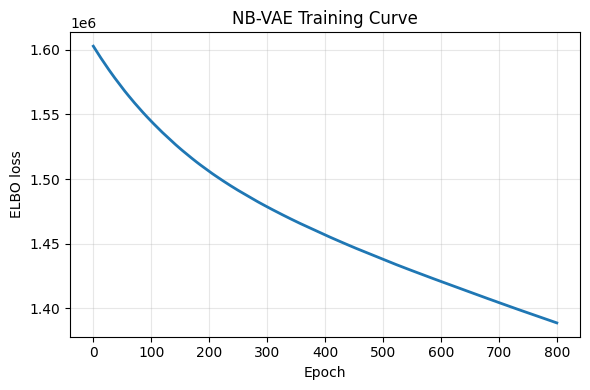

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(losses, lw=2)
plt.xlabel("Epoch")
plt.ylabel("ELBO loss")
plt.title("NB-VAE Training Curve")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show();

Visualization of the ELBO loss, steady decrease with no instability is observed.

In [ ]:
with torch.no_grad():
    _, mu_z, _ = model(X_enc, log_size_factors)

z = mu_z.cpu().numpy()

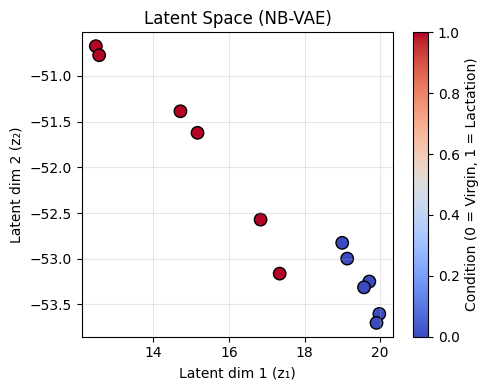

In [ ]:
plt.figure(figsize=(5,4))

scatter = plt.scatter(
    z[:, 0],
    z[:, 1],
    c=y.cpu().numpy(),
    cmap="coolwarm",
    s=80,
    edgecolor="k"
)

plt.xlabel("Latent dim 1 (z₁)")
plt.ylabel("Latent dim 2 (z₂)")
plt.title("Latent Space (NB-VAE)")

cbar = plt.colorbar(scatter)
cbar.set_label("Condition (0 = Virgin, 1 = Lactation)")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show();

Visualization of the two-dimensional latent space learned by the NB-VAE. Each point represents a sample, colored by experimental condition for interpretive purposes only. Although condition labels were not used during training, samples from lactation and virgin states separate clearly along the latent dimensions, indicating that the model has learned a biologically meaningful representation of transcriptional variation in an unsupervised manner.

In [ ]:
model.eval()

with torch.no_grad():
    log_mu, mu_z, logvar_z = model(X_enc, log_size_factors)

In [ ]:
log_mu_lact = log_mu[y == 1]
log_mu_virg = log_mu[y == 0]

print(log_mu_lact.shape, log_mu_virg.shape)

torch.Size([6, 18178]) torch.Size([6, 18178])


The model-predicted log mean expression values are separated by experimental condition to enable downstream comparison. Although condition labels were not used during training, they are applied here solely for post hoc interpretation of the learned generative model.

In [ ]:
logFC_gen = log_mu_lact.mean(dim=0) - log_mu_virg.mean(dim=0)

Generative log fold-change estimates are computed by taking the difference between the average predicted log expression in lactation and virgin samples. This quantity represents the model’s expected change in gene expression between the two biological states, derived from the learned latent representation rather than direct statistical testing.

In [ ]:
model_genes = counts_filtered.index[keep_genes.cpu().numpy()]
print(model_genes.shape)

(18178,)


In [ ]:
gen_de = pd.DataFrame(
    {
        "logFC_gen": logFC_gen.cpu().numpy(),
        "NA_deseq2": na_mask.cpu().numpy()
    },
    index=model_genes
)

In [ ]:
merged = gen_de.join(
    deseq2[["log2FoldChange", "padj"]],
    how="left"
)

A unified results table is constructed by combining generative differential expression estimates with classical DESeq2 outputs. The generative log fold-change values are stored alongside a flag indicating whether each gene had an NA adjusted p-value in DESeq2, and then merged with DESeq2 log2 fold changes and adjusted p-values. This integrated table enables direct gene-level comparison between the generative model and classical differential expression results, including explicit evaluation of genes that could not be reliably tested by DESeq2.

In [ ]:
valid = merged["padj"].notna()

corr = np.corrcoef(
    merged.loc[valid, "log2FoldChange"],
    merged.loc[valid, "logFC_gen"]
)[0, 1]

print("Correlation (DESeq2 vs Gen):", corr)

Correlation (DESeq2 vs Gen): 0.659908238831422


The Pearson correlation between DESeq2 log2 fold-change estimates and generative log fold changes is moderately high, indicating substantial agreement between the classical statistical approach and the generative model while still allowing for meaningful differences in effect size estimation.

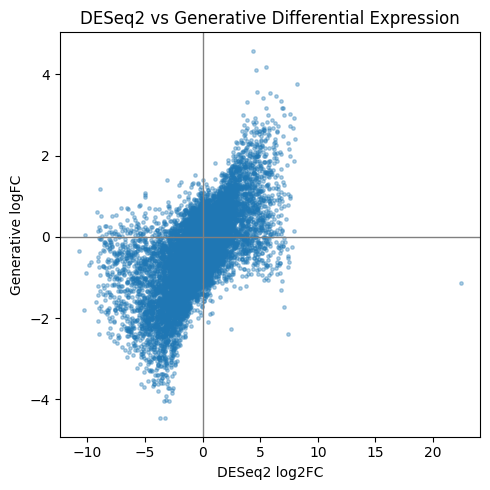

In [ ]:
plt.figure(figsize=(5,5))

plt.scatter(
    merged.loc[valid, "log2FoldChange"],
    merged.loc[valid, "logFC_gen"],
    s=6,
    alpha=0.35
)

plt.axhline(0, color="gray", lw=1)
plt.axvline(0, color="gray", lw=1)

plt.xlabel("DESeq2 log2FC")
plt.ylabel("Generative logFC")
plt.title("DESeq2 vs Generative Differential Expression")

plt.tight_layout()
plt.show();

Visualization of the scatter plot comparing classical DESeq2 log2 fold-change estimates with generative log fold changes derived from the NB-VAE. Each point represents a gene. The positive correlation indicates strong overall agreement between the two approaches, while deviations from the diagonal reflect differences arising from the generative model’s shrinkage and uncertainty-aware estimation.

In [ ]:
na_genes = merged[merged["padj"].isna()]
na_genes.sort_values("logFC_gen", ascending=False).head(10)

,logFC_gen,NA_deseq2,log2FoldChange,padj
EntrezGeneID,,,,
215866,0.454997,True,5.177759,NaN
18948,-0.183478,True,5.788305,NaN
19259,-0.942599,True,7.134686,NaN
382231,-1.383121,True,-1.904977,NaN
212753,-1.588778,True,-2.480648,NaN


Genes with missing adjusted p-values in DESeq2 are isolated and ranked by their generative log fold-change estimates. Although these genes could not be reliably tested using classical statistical methods due to sparse or unstable counts, the generative model assigns finite and directional effect size estimates, demonstrating its ability to provide biologically interpretable information for genes typically excluded from standard differential expression analysis.

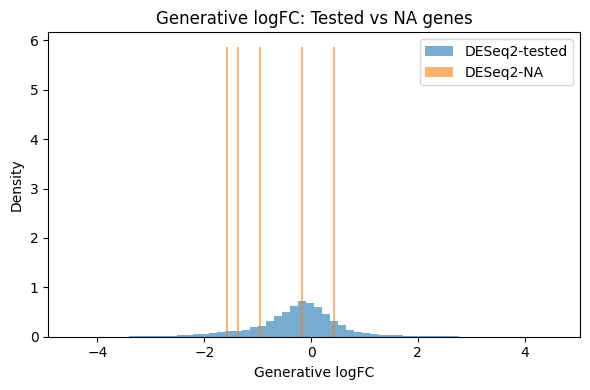

In [ ]:
plt.figure(figsize=(6,4))

plt.hist(
    merged.loc[valid, "logFC_gen"],
    bins=60,
    alpha=0.6,
    label="DESeq2-tested",
    density=True
)

plt.hist(
    na_genes["logFC_gen"],
    bins=60,
    alpha=0.6,
    label="DESeq2-NA",
    density=True
)

plt.xlabel("Generative logFC")
plt.ylabel("Density")
plt.legend()
plt.title("Generative logFC: Tested vs NA genes")

plt.tight_layout()
plt.show();

Distribution of generative log fold-change estimates for genes successfully tested by DESeq2 compared with genes assigned NA adjusted p-values. While DESeq2-tested genes show a smooth, approximately centered distribution, NA genes exhibit sparser and more variable generative estimates, reflecting higher uncertainty due to low or uneven counts. Nevertheless, the generative model assigns finite, directional effect sizes to these genes, highlighting its ability to extend differential expression analysis beyond the limits of classical hypothesis testing.

In [ ]:
gen_ranked = merged.sort_values("logFC_gen", ascending=False)
gen_ranked.head(20)

,logFC_gen,NA_deseq2,log2FoldChange,padj
EntrezGeneID,,,,
258173,4.585882,False,4.380753,1.690886e-01
100042304,4.177666,False,5.482814,2.592945e-02
193217,4.099132,False,4.665764,6.662443e-02
55961,3.770663,False,8.200022,4.420000e-05
100862376,3.563008,False,4.754516,2.291627e-02
75019,3.544240,False,5.896642,1.579260e-04
791378,3.481015,False,6.411264,5.628568e-02
78446,3.414657,False,5.267839,8.120268e-02
241612,3.348746,False,6.808228,8.739462e-03


In [ ]:
gen_ranked = merged.copy()

gen_ranked = gen_ranked.sort_values("logFC_gen", ascending=False)

In [ ]:
top_n = 500

gen_up = gen_ranked.head(top_n).index.astype(str).tolist()
gen_down = gen_ranked.tail(top_n).index.astype(str).tolist()

print(len(gen_up), len(gen_down))

500 500


In [ ]:
pd.Series(gen_up).to_csv("gen_up_entrez.csv", index=False, header=False)
pd.Series(gen_down).to_csv("gen_down_entrez.csv", index=False, header=False)

The top-ranked generative differentially expressed genes are selected by ranking genes according to the magnitude of their generative log fold-change estimates. The most strongly upregulated and downregulated genes are retained and exported as Entrez gene ID lists for downstream pathway enrichment analysis. These files serve as inputs for Gene Ontology and KEGG analyses performed in R, enabling direct comparison between pathway-level signals derived from generative differential expression and those obtained using classical DESeq2 results.